Perform correlation analysis of the dataset to identify relationships that might indicate a causal connection with the bubble issue.

In [122]:
import os
import datetime
import pandas as pd
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder

# define the substring of an HT section
ht_part_number = {
    'Type': [0,1],
    'Height': [1,3],
    'Construction': [3,4],
    'Color': [4,5],
    'Thickness': [6,7],
    'Outside Skin': [7,8],
    'Outside Treatment': [8,9],
    'Outside Grooving':[9,10],
    'Inside Skin': [11,12],
    'Inside Grooving': [12,13],
    'Length': [14,18],
    'End Stiles': [18,19],
    'Backer Stile Placement': [19,20]
}

# combine all sheets from an excel file
def read_and_concat_sheets(file_path, selected_columns):
    # Read the Excel file into an ExcelFile object
    excel_file = pd.ExcelFile(file_path)

    # Create an empty list to store the DataFrames
    dfs = []

    # Iterate through each sheet in the Excel file
    for sheet_name in excel_file.sheet_names:
        # Read the sheet into a DataFrame
        df = excel_file.parse(sheet_name, usecols=selected_columns)        
        # Append the DataFrame to the list
        dfs.append(df)
    # Concatenate all the DataFrames into one
    concatenated_df = pd.concat(dfs, ignore_index=True)

    return concatenated_df

# data file
file_path = Path('2024_customer_feedback_bubble.xlsx')
selected_columns = ['Line', 'Blend','EndOfPourTimeStamp', 'SmartPartNumber']

# make sure the file exists
if file_path.is_file():
     
    ## convert to csv because it's faster for subsequent processing
     base_name, ext = os.path.splitext(file_path)
     csv_file_path = Path(base_name + '.csv')

     if csv_file_path.is_file():
         print(str(csv_file_path) + ' already exists!')
     else:
         df = read_and_concat_sheets(file_path, selected_columns)
         # Write the DataFrame to a CSV file
         df.to_csv(csv_file_path, index=False)
         print(f'{csv_file_path} has been created.')


2024_customer_feedback_bubble.csv already exists!
Loading data . . .
Done


In [130]:
print("Loading data . . .")
df = pd.read_csv(csv_file_path)

part_dict = df.to_dict()
print("Processing . . .")

# disect the part number and make columns for each definition
for option, loc in ht_part_number.items():
    part_dict[option] = {}
    for i, part_no in part_dict['SmartPartNumber'].items():
        part_dict[option][i] = part_no[loc[0]:loc[1]]


# convert EndOfPourTimeStamp into pandas date/time
# then make Year, Month and Day and Hour columns
part_dict['Year']  = {}
part_dict['Month']  = {}
part_dict['Day of Week']  = {}
part_dict['Hour']  = {}
for i, date_time in part_dict['EndOfPourTimeStamp'].items(): 
    try:                                                
        part_dict['EndOfPourTimeStamp'][i] = datetime.datetime.strptime(date_time,"%Y-%m-%d %H:%M:%S")
        part_dict['Day of Week'][i] = part_dict['EndOfPourTimeStamp'][i].weekday()
        part_dict['Month'][i] = part_dict['EndOfPourTimeStamp'][i].month
        part_dict['Year'][i] = part_dict['EndOfPourTimeStamp'][i].year
        part_dict['Hour'][i] = part_dict['EndOfPourTimeStamp'][i].hour
    except:
        print(f'Invalid date in row {i}')


df = pd.DataFrame.from_dict(part_dict)

firstDate, lastDate = df['EndOfPourTimeStamp'].min(), df['EndOfPourTimeStamp'].max()

print(f'From {firstDate} to {lastDate}')

# delete the original EndOfPourTimeStamp 
df.drop('EndOfPourTimeStamp', axis=1, inplace=True)
# delete the SmartPartNumber 
df.drop('SmartPartNumber', axis=1, inplace=True)

df_shape = df.shape
df.dropna(inplace=True)
df_new_shape = df.shape

dropped_rows = df_shape[0] - df_new_shape[0]
print(f'*{dropped_rows} rows were dropped due to incomplete data.')

# remove uniform columns
uniform_columns = [col for col in df.columns if df[col].nunique() == 1]
print(str(uniform_columns) + " contain homogeneous data and have been removed.")
df = df.drop(columns=uniform_columns)

# Create a LabelEncoder object
le = LabelEncoder()

# Apply label encoding to all categorical columns
for col in df.columns:
    if df[col].dtype == 'object':
        df[col] = le.fit_transform(df[col])

# Perform a correlation analysis using the `corr()` method
correlation_matrix = df.corr()

# Print the correlation matrix
print(correlation_matrix)

Loading data . . .
Processing . . .
Invalid date in row 217371
Invalid date in row 387513
Invalid date in row 519977
Invalid date in row 519978
Invalid date in row 519979
Invalid date in row 519980
From 2020-01-02 06:41:18 to 2024-09-14 12:35:04
*6 rows were dropped due to incomplete data.
['Inside Grooving'] contain homogeneous data and have been removed.
                            Line     Blend      Type    Height  Construction  \
Line                    1.000000 -0.001019  0.103593  0.196721      0.065549   
Blend                  -0.001019  1.000000 -0.003626  0.017779     -0.498953   
Type                    0.103593 -0.003626  1.000000  0.021703     -0.009732   
Height                  0.196721  0.017779  0.021703  1.000000     -0.041826   
Construction            0.065549 -0.498953 -0.009732 -0.041826      1.000000   
Color                   0.082625  0.002276 -0.002388  0.024737     -0.000741   
Thickness              -0.197318  0.046124 -0.005254  0.119863     -0.275121   
O

The correlation matrix will contain the Pearson correlation coefficients between each pair of variables. A value closer to 1 indicates a strong positive relationship, while values closer to -1 indicate a strong negative relationship. Values close to zero suggest no linear relationship between two variables.

In [124]:
# Identify the most correlated variables
most_correlated_variables = correlation_matrix.unstack().sort_values(ascending=False)[1:]

# Print the most correlated variables
print('Most correlated variables:')
print(most_correlated_variables)

Most correlated variables:
Line                    Line                      1.000000
Month                   Month                     1.000000
Year                    Year                      1.000000
Type                    Type                      1.000000
Backer Stile Placement  Backer Stile Placement    1.000000
                                                    ...   
Length                  Backer Stile Placement   -0.323545
Blend                   Construction             -0.498953
Construction            Blend                    -0.498953
Year                    Construction             -0.595615
Construction            Year                     -0.595615
Length: 323, dtype: float64


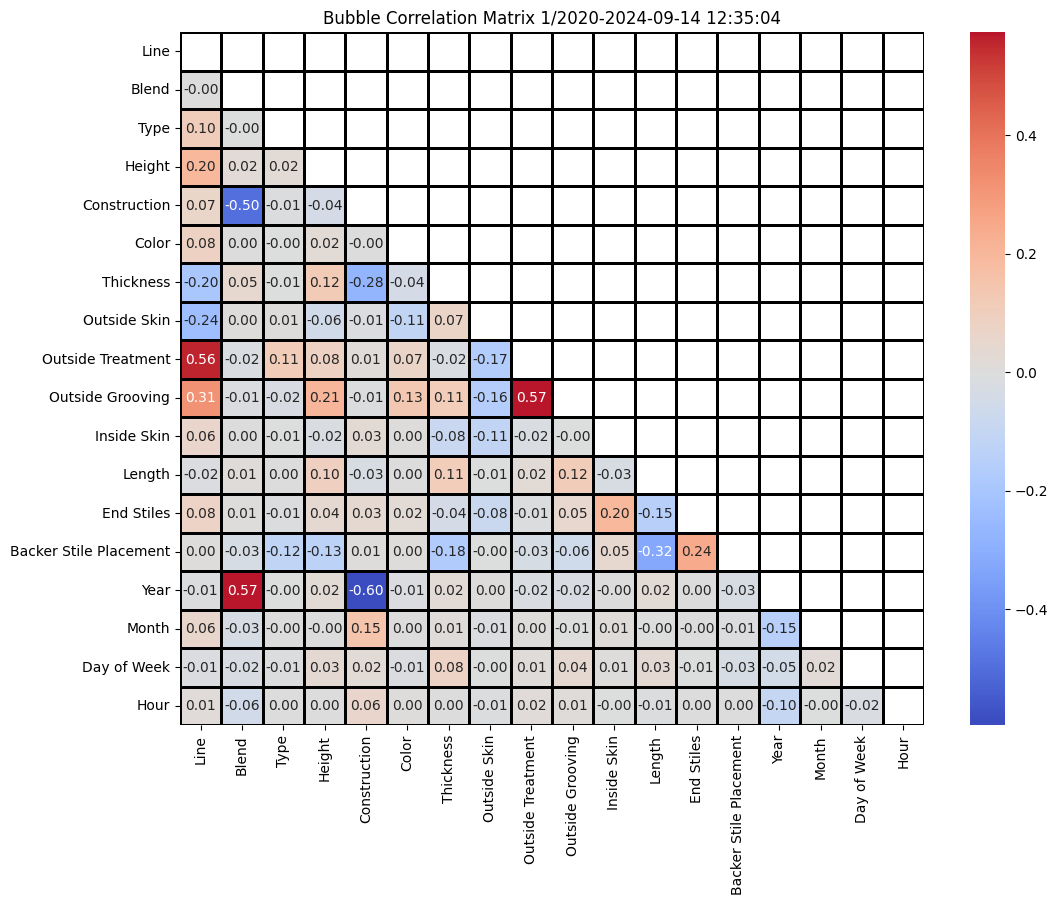

In [132]:
# Create a heatmap using Seaborn
plt.figure(figsize=(12, 9))
matrix = np.triu(df.corr())
sns.heatmap(correlation_matrix, 
            annot=True, 
            cmap='coolwarm', 
            cbar=True, 
            fmt=".2f",
            center=0,
            linewidths=2, 
            linecolor='black',
            mask=matrix
            )

# Add a title
plt.title(f'Bubble Correlation Matrix {firstDate.month}/{firstDate.year}-{lastDate.month}/{lastDate.year}')

# Show the plot
plt.show()